# Neural Network Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
#数据处理
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']
X = np.hstack((np.ones((X.shape[0],1)),X))
X.shape


(5000, 401)

## 1. 成本函数（无正则化）
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K} \left[ -y_{k}^{(i)} \log((h_{\theta}(x^{(i)}))_k) - (1 - y_{k}^{(i)}) \log(1 - (h_{\theta}(x^{(i)}))_k) \right] $$


## 2. 正则化成本函数
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K} \left[ -y_{k}^{(i)} \log((h_{\theta}(x^{(i)}))_k) - (1 - y_{k}^{(i)}) \log(1 - (h_{\theta}(x^{(i)}))_k) \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2 \right] $$


## 3. Sigmoid函数的梯度
$$ g'(z) = \frac{d}{dz} g(z) = g(z)(1 - g(z)) $$
其中：
$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [3]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-z))

In [4]:
def sigmoid_gradient(z: np.ndarray) -> np.ndarray:
    return sigmoid(z) * (1 - sigmoid(z))

![Screenshot 2025-08-11 155017.png](<attachment:Screenshot 2025-08-11 155017.png>)
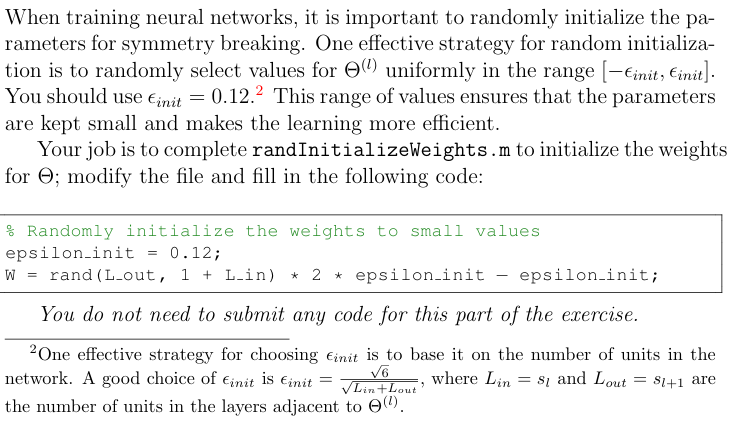

In [5]:
# 随机初始化权重为小值， 以便找到权重对输入输出的影响
def randInitializeWeights(L_in: int, L_out: int) -> np.ndarray:
    epsilon_init = np.sqrt(6/(L_in + L_out))
    # 随机初始化权重矩阵W，范围在[-epsilon_init, epsilon_init]
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

Theta1 = randInitializeWeights(X.shape[1]-1, 500)
Theta2 = randInitializeWeights(500, 10)# 隐藏层25个节点（注意偏置项bias term），输出层10个节点

print(Theta1.shape, Theta2.shape)

Theta1 = Theta1.T
Theta2 = Theta2.T

(500, 401) (10, 501)


In [6]:
# 前向传播
def feedforward_pass(X: np.ndarray, Theta1: np.ndarray, Theta2: np.ndarray) -> tuple:
    """
    执行神经网络的前向传播
    参数:
    X: 输入数据，形状为(m, n+1)，其中m是样本数，n是特征数
    Theta1: 第一层权重，形状为(p, n+1)，其中p是隐藏层神经元数
    Theta2: 第二层权重，形状为(k, p+1)，其中k是输出类别数
    返回:
    tuple: 包含z1, a1, z2, a2
    """
    m = X.shape[0]
    
    # 第一层计算
    z1 = X @ Theta1.T
    a1 = sigmoid(z1)
    a1 = np.hstack((np.ones((m, 1)), a1))  # 添加偏置项
    
    # 第二层计算
    z2 = a1 @ Theta2.T
    a2 = sigmoid(z2)
    
    return z1, a1, z2, a2


## 4. 反向传播算法中的误差项
- 输出层误差：
$$ \delta_{k}^{(3)} = (a_{k}^{(3)} - y_k) $$
- 隐藏层误差：
$$ \delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)} \ast g'(z^{(2)}) $$

$$\mathrm{\Delta}^{\left(l\right)}=\mathrm{\Delta}^{\left(l\right)}+\delta^{\left(l+1\right)}\left(a^{\left(l\right)}\right)^T$$


![Screenshot 2025-08-11 162537.png](<attachment:Screenshot 2025-08-11 162537.png>)
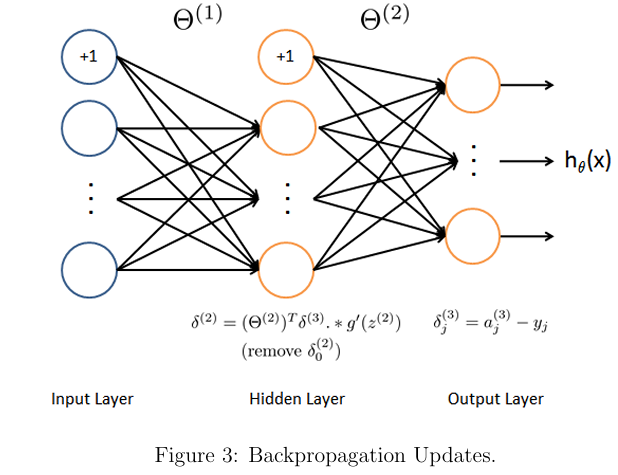


---

### 1. **误差项的定义**
误差项 $\delta^{(l)}_j$ 表示第 l 层的第 j 个神经元对最终输出误差的“贡献”。数学上，它定义为：

$$
\delta^{(l)}_j = \frac{\partial J}{\partial z^{(l)}_j}
$$

其中：
- \(J\) 是损失函数（如均方误差或交叉熵）。
- $z^{(l)}_j$ 是第 \(l\) 层第 \(j\) 个神经元的加权输入（即激活函数的输入）。

---

### 2. **输出层的误差 $\delta^{(3)}$**
对于输出层（第 3 层），误差直接由预测值 \(a^{(3)}_j\) 和真实标签 \(y_j\) 的差异决定。以均方误差为例：

$$
J = \frac{1}{2} \sum_{j} (a^{(3)}_j - y_j)^2
$$

计算梯度：

$$
\delta^{(3)}_j = \frac{\partial J}{\partial z^{(3)}_j} = \frac{\partial J}{\partial a^{(3)}_j} \cdot \frac{\partial a^{(3)}_j}{\partial z^{(3)}_j}
$$

假设激活函数为 Sigmoid（ $a^{(3)}_j = \sigma(z^{(3)}_j)$），则：
- $\frac{\partial J}{\partial a^{(3)}_j} = a^{(3)}_j - y_j$（损失函数的梯度）。
- $\frac{\partial a^{(3)}_j}{\partial z^{(3)}_j} = \sigma^{\prime}(z^{(3)}_j) = a^{(3)}_j (1 - a^{(3)}_j)$（Sigmoid 的导数）。

因此：

$$
\delta^{(3)}_j = (a^{(3)}_j - y_j) \cdot a^{(3)}_j (1 - a^{(3)}_j)
$$

但在某些简化形式（或使用交叉熵损失时），Sigmoid 的导数项会被抵消，最终简化为：

$$
\delta^{(3)}_j = a^{(3)}_j - y_j
$$

---

### 3. **倒数第二层的误差 $\delta^{(2)}$**
倒数第二层的误差需要通过链式法则，从输出层的误差反向传播得到：

$$
\delta^{(2)} = \frac{\partial J}{\partial z^{(2)}}
$$

根据链式法则：

$$
\frac{\partial J}{\partial z^{(2)}} = \frac{\partial J}{\partial z^{(3)}} \cdot \frac{\partial z^{(3)}}{\partial a^{(2)}} \cdot \frac{\partial a^{(2)}}{\partial z^{(2)}}
$$

展开分析：
1. **第一项 $\frac{\partial J}{\partial z^{(3)}}$**：即输出层的误差 $\delta^{(3)}\$。
2. **第二项 $\frac{\partial z^{(3)}}{\partial a^{(2)}}$**：  
   $z^{(3)} = \Theta^{(2)} a^{(2)} + \text{bias}$，因此 $\frac{\partial z^{(3)}}{\partial a^{(2)}} = \Theta^{(2)}$。  
   转置后得到 $(\Theta^{(2)})^T$（因为反向传播是“反向”的权重矩阵）。
3. **第三项 $\frac{\partial a^{(2)}}{\partial z^{(2)}}$**：即激活函数的导数 $g^{\prime}(z^{(2)})$。

将三项结合，并逐元素相乘（.*）：

$$
\delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)} \, .* \, g^{\prime}(z^{(2)})
$$

---

### 4. **直观理解**
- **权重矩阵转置 $(\Theta^{(2)})^T$**：将输出层的误差“反向投影”到倒数第二层，反映每个神经元对误差的贡献权重。
- **激活函数导数 $g^{\prime}(z^{(2)})$**：调整误差通过激活函数时的变化率（例如，Sigmoid 的导数会抑制梯度饱和区域的误差）。



### 5. 梯度计算（无正则化）
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \delta_{ij}^{(l)} $$


### 6. 梯度计算（带正则化）
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \delta_{ij}^{(l)} \quad \text{（当 } j = 0 \text{）} $$
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} \quad \text{（当 } j \geq 1 \text{）} $$


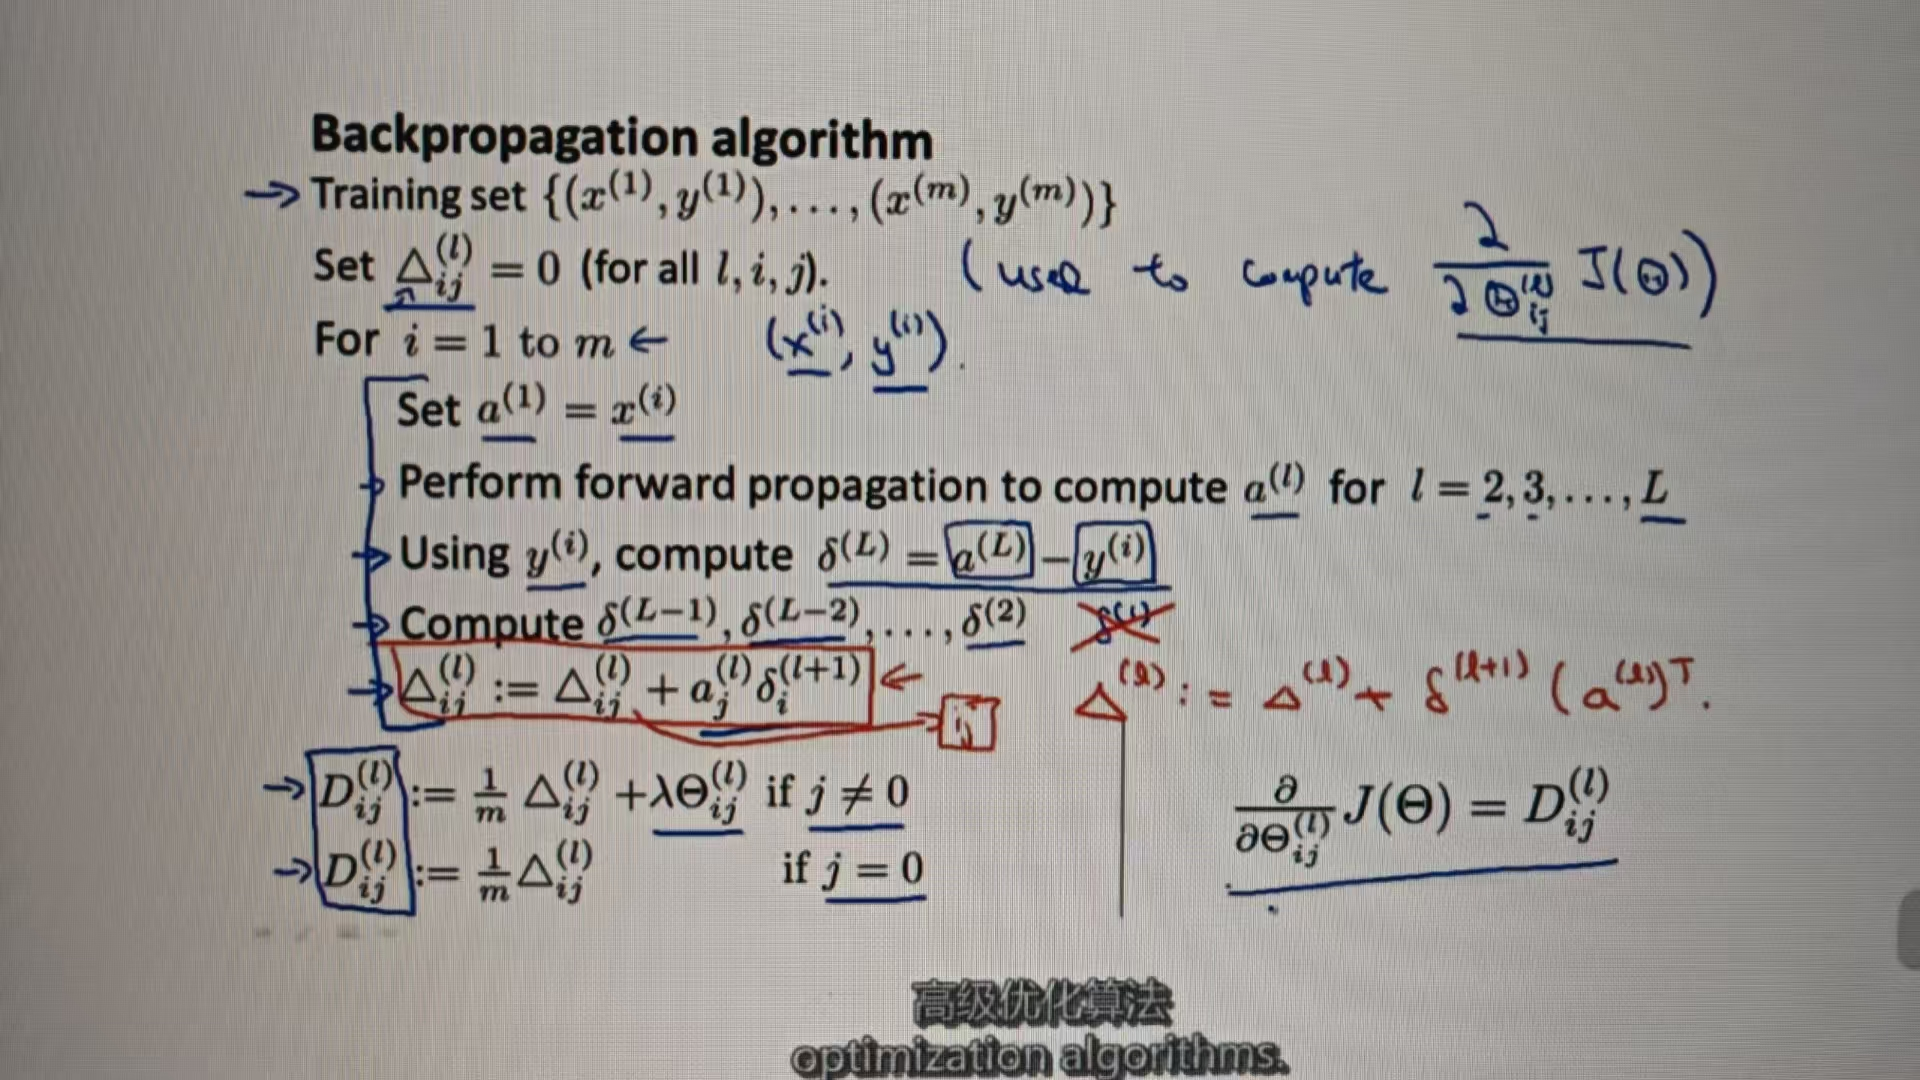

### 7. 数值梯度检查
$$ f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon} $$
其中：
$$ \theta^{(i+)} = \theta + \epsilon \cdot \mathbf{e}_i, \quad \theta^{(i-)} = \theta - \epsilon \cdot \mathbf{e}_i $$

![Screenshot 2025-08-11 210951.png](<attachment:Screenshot 2025-08-11 210951.png>)
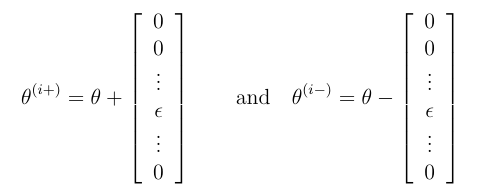

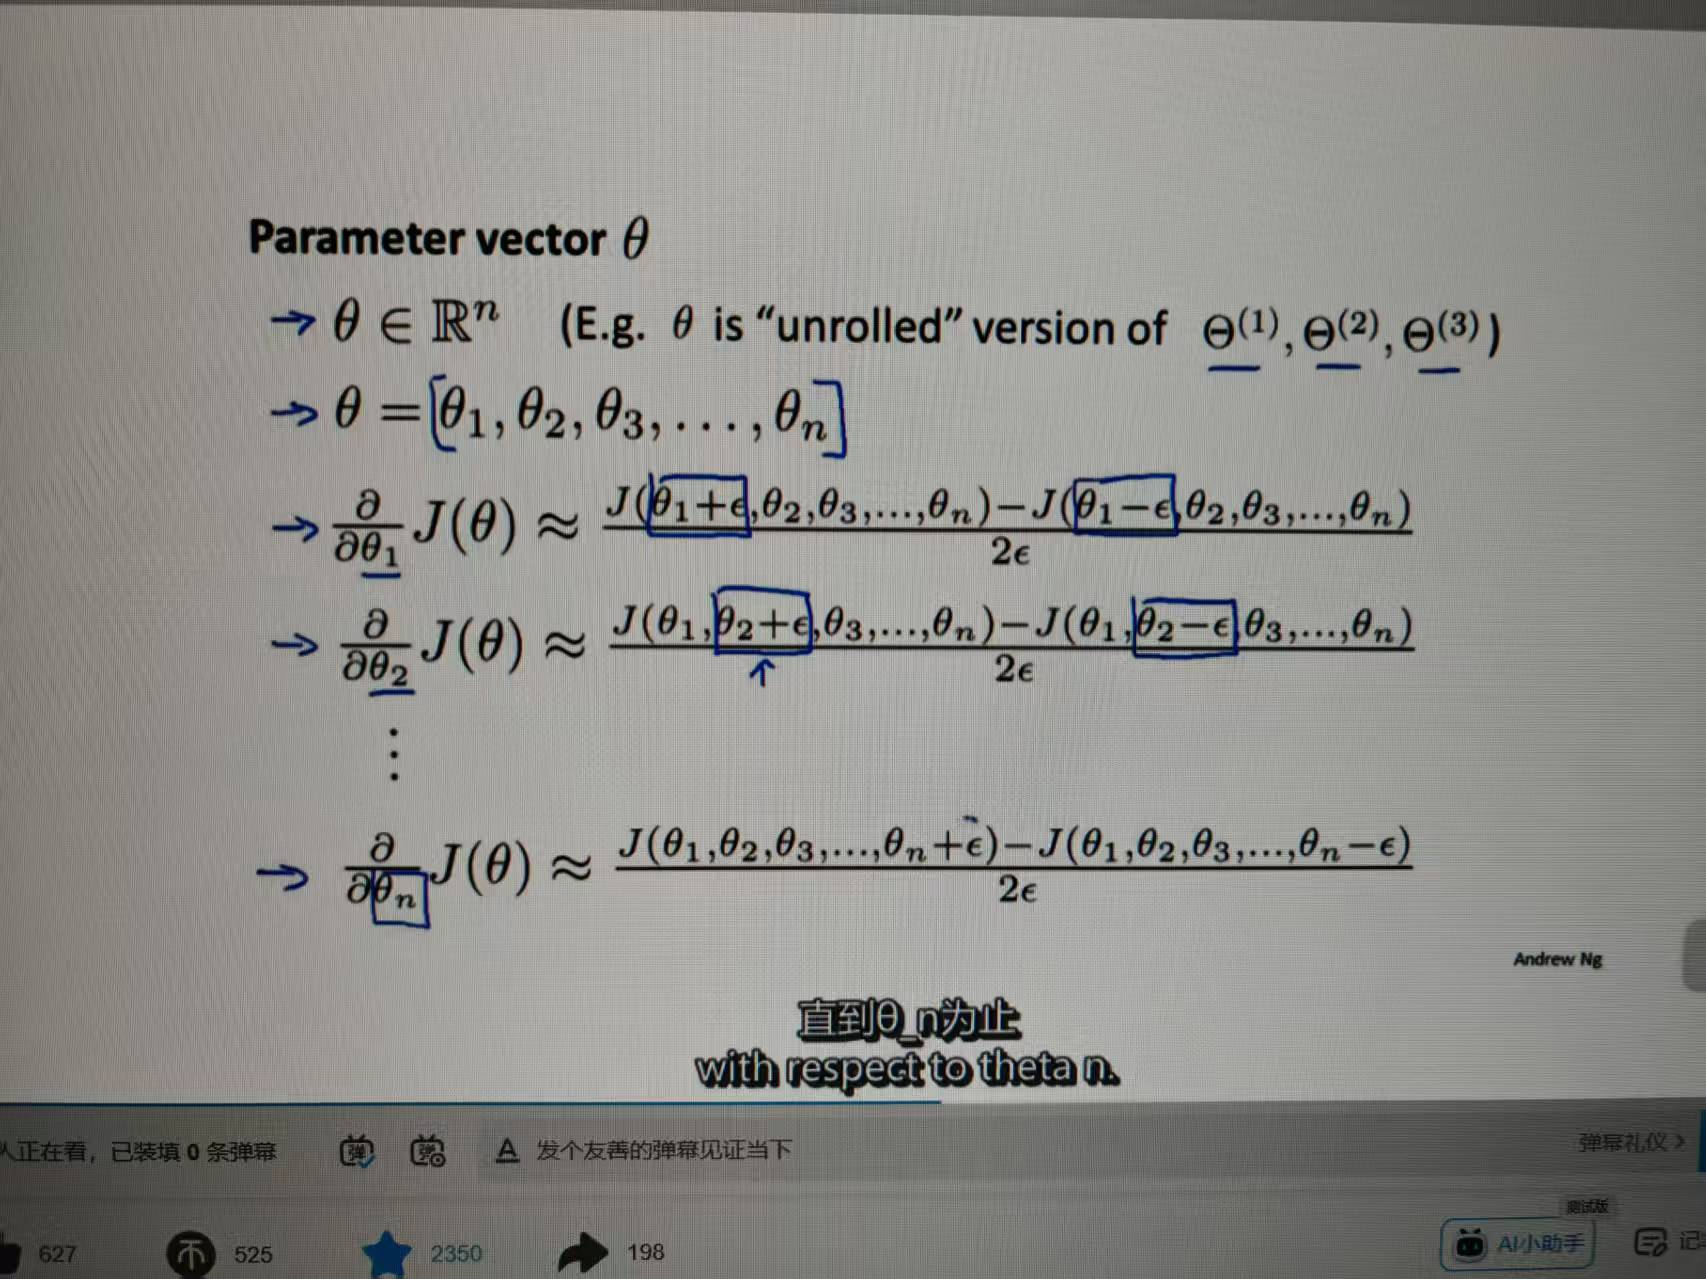

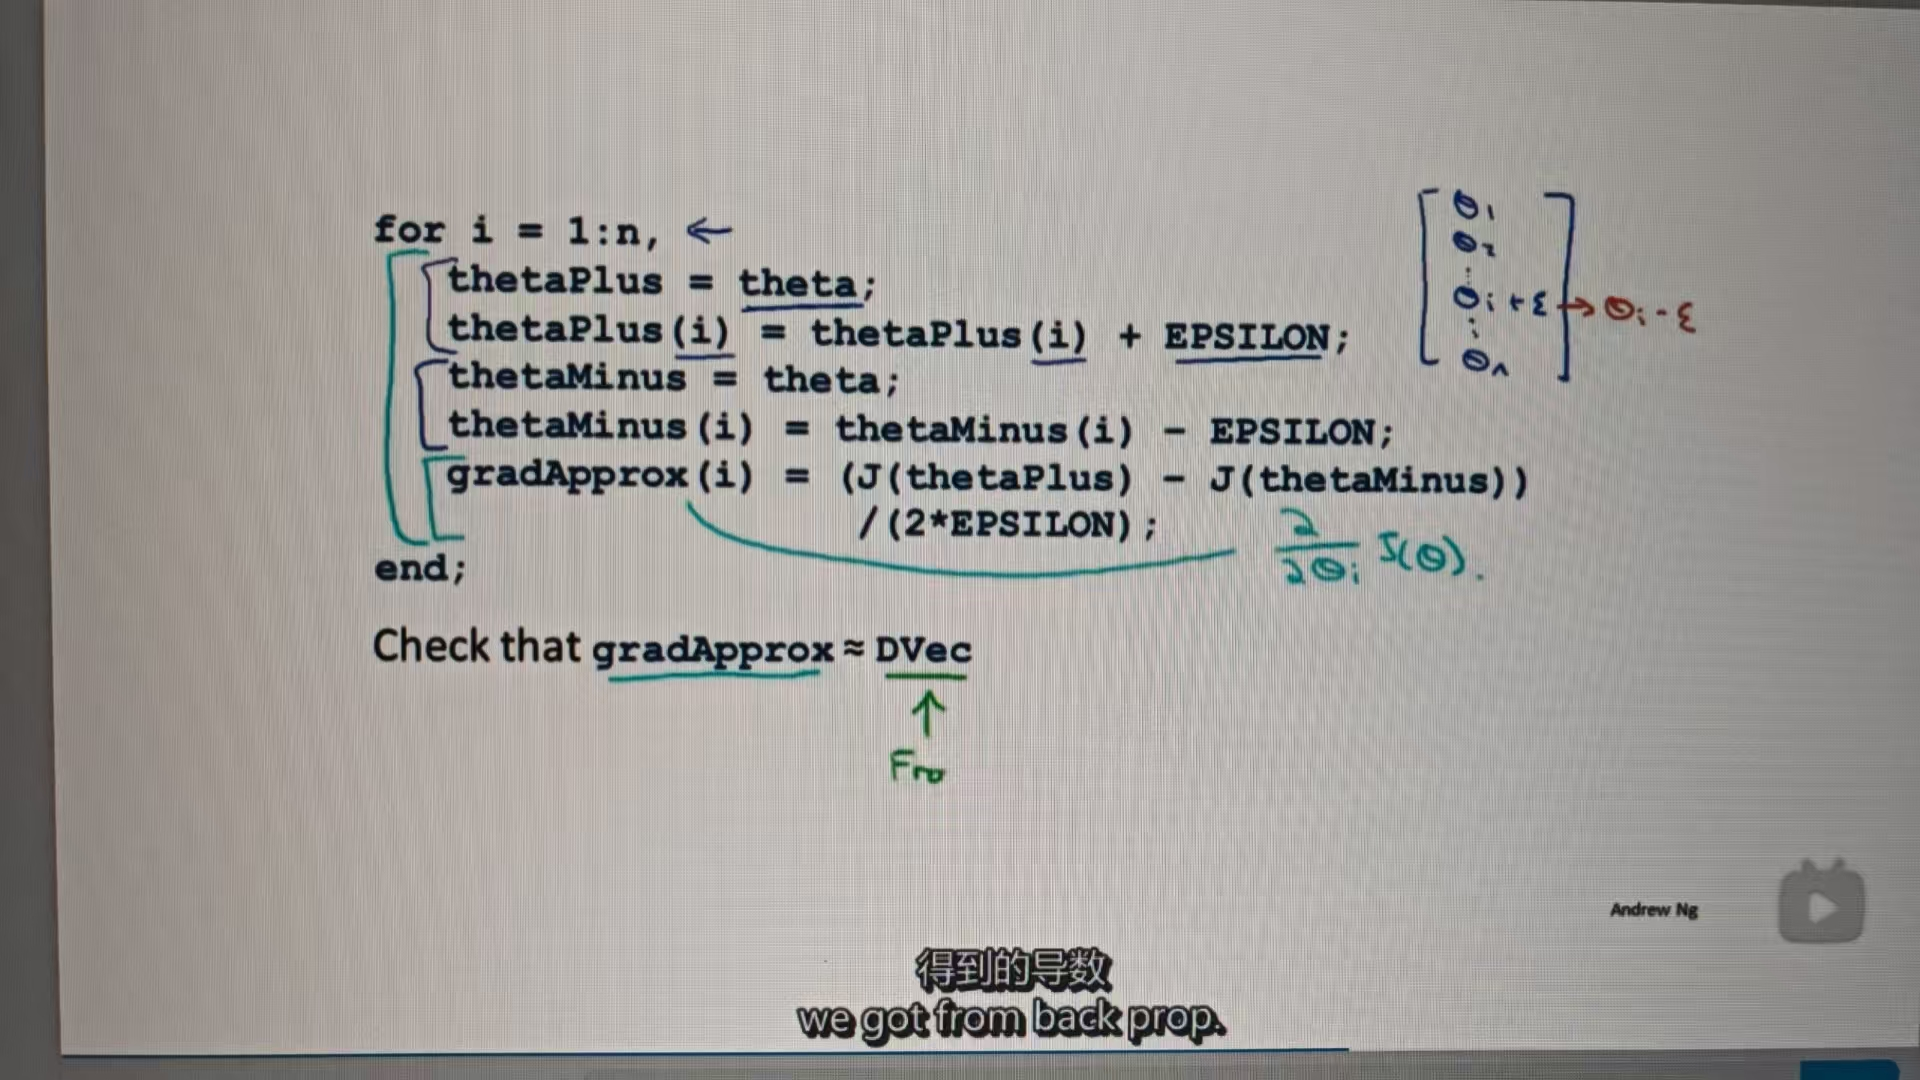

### 梯度下降检验消耗大量时间，一旦确定模型正确不要再使用它训练模型

### One-Hot Encoding Formula

The code converts a vector of labels `y` into a one-hot encoded matrix `y_matrix`:

```python
y_matrix = np.eye(K)[y.flatten() - 1]  # Shape: (m, 10)

In [7]:
# 反向传播，全批更新权重
def NN_backpropagation(X: np.ndarray, y: np.ndarray, Theta1: np.ndarray, Theta2: np.ndarray, lambda_: float) -> tuple:
    """
    执行神经网络的反向传播
    参数:
    X: 输入数据，形状为(m, n+1)
    y: 标签，形状为(m, 1)
    Theta1: 第一层权重，形状为(p, n+1)
    Theta2: 第二层权重，形状为(k, p+1)
    lambda_: 正则化参数
    返回:
    tuple: 包含更新后的Theta1和Theta2
    """
    m = X.shape[0]
    k = Theta2.shape[0]  # 输出类别数
    
    # 初始化梯度
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    for i in range(m):
        x_i = X[i, :].reshape(1, -1)
        y_i = y[i, 0]
        
        # 前向传播
        z1, a1, z2, a2 = feedforward_pass(x_i, Theta1, Theta2)
        
        # 构建one-hot编码的标签
        y_onehot = np.zeros((1, k))
        y_onehot[0, y_i - 1] = 1  # 类别从1开始，转为0索引
        
        # 计算误差
        delta2 = a2 - y_onehot  # 输出层误差 1*k
        # 隐藏层误差（不包括偏置项）
        delta1 = (delta2 @ Theta2[:, 1:]) * sigmoid_gradient(z1)# 1*k x k*p .* p*n = 1*n
        
        # 累积梯度
        Theta1_grad += delta1.T @ x_i # n*1 x 1*(n+1) = n*(n+1)
        Theta2_grad += delta2.T @ a1 # k*1 x 1*(p+1) = k*(p+1)
    
    #检验梯度
    # ...
    
    # 计算平均梯度
    Theta1_grad /= m
    Theta2_grad /= m
    
    # 添加正则化项（不包括偏置项）
    Theta1_grad[:, 1:] += (lambda_ / m) * Theta1[:, 1:]
    Theta2_grad[:, 1:] += (lambda_ / m) * Theta2[:, 1:]
    
    # 更新权重
    Theta1 -= Theta1_grad
    Theta2 -= Theta2_grad
    
    return Theta1, Theta2
    

In [8]:
# 反向传播，逐批更新权重
def NN_batch_backpropagation(X:np.ndarray, y:np.ndarray, Theta1:np.ndarray, Theta2:np.ndarray, lambda_:float, batch_size:int)->tuple:

    for i in range(0, X.shape[0], batch_size):
        if i + batch_size > X.shape[0]:
            X_batch = X[i:, :]
            y_batch = y[i:, :]
        else:
            X_batch = X[i:i+batch_size, :]
            y_batch = y[i:i+batch_size, :]
        z1, a1, z2, a2 = feedforward_pass(X_batch, Theta1, Theta2)
        
        m = X_batch.shape[0]

        y_onehot = np.zeros((m, Theta2.shape[0]))
        for j in range(m):
            y_i = y_batch[j, 0]
            y_onehot[j, y_i - 1] = 1
        # 计算误差
        delta2 = a2 - y_onehot  # 输出层误差 m*k
        delta1 = (delta2 @ Theta2[:, 1:]) * sigmoid_gradient(z1)  # m*k x k*p .* p*n = m*n

        # 累积梯度
        Theta1_grad = delta1.T @ X_batch  # n*m x m*(n+1) = n*(n+1)
        Theta2_grad = delta2.T @ a1  # k*m x m*(p+1) = k*(p+1)

        # 计算平均梯度
        Theta1_grad /= m
        Theta2_grad /= m

        # 添加正则化项（不包括偏置项）(所有行的非偏置项添加正则化项，代码和逐样本更新相同)
        Theta1_grad[:, 1:] += (lambda_ / m) * Theta1[:, 1:]
        Theta2_grad[:, 1:] += (lambda_ / m) * Theta2[:, 1:]

        # 更新权重
        Theta1 -= Theta1_grad
        Theta2 -= Theta2_grad

        

    return Theta1, Theta2




In [9]:

# 预测函数
def predict(Theta1, Theta2, X):
    # 确保X包含偏置项
    if X.shape[1] == Theta1.shape[1] - 1:
        X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # 前向传播
    _, _, _, a2 = feedforward_pass(X, Theta1, Theta2)
    
    # 返回预测结果（概率最大的类别）
    return np.argmax(a2, axis=1) + 1  # 类别从1开始


In [10]:
# 训练神经网络
def train_neural_network(X, y, hidden_layer_size=25, num_labels=10, lambda_=1, num_iterations=1000, batch_size=1):
    # 初始化权重
    Theta1 = randInitializeWeights(X.shape[1] - 1, hidden_layer_size)
    Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    
    # 迭代训练
    for i in range(num_iterations):
        # Theta1, Theta2 = NN_backpropagation(X, y, Theta1, Theta2, lambda_)
        Theta1, Theta2 = NN_batch_backpropagation(X, y, Theta1, Theta2, lambda_, batch_size)
        
        # 每100次迭代打印一次进度
        if (i+1) % 500 == 0:
            predictions = predict(Theta1, Theta2, X[:, 1:])  # 去掉偏置项
            accuracy = np.mean(predictions == y.flatten())
            print(f'迭代 {i+1}/{num_iterations}, 准确率: {accuracy:.4f}')
    
    return Theta1, Theta2


In [11]:
# 打乱样本
np.random.seed(114514)  # 设置随机种子以确保可重复性
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

Theta1, Theta2 = train_neural_network(X, y, hidden_layer_size=500, num_iterations=10000, batch_size = 1000)

迭代 500/10000, 准确率: 0.9548
迭代 1000/10000, 准确率: 0.9628
迭代 1500/10000, 准确率: 0.9650
迭代 2000/10000, 准确率: 0.9656
迭代 2500/10000, 准确率: 0.9680
迭代 3000/10000, 准确率: 0.9690
迭代 3500/10000, 准确率: 0.9698
迭代 4000/10000, 准确率: 0.9704
迭代 4500/10000, 准确率: 0.9696
迭代 5000/10000, 准确率: 0.9694
迭代 5500/10000, 准确率: 0.9696
迭代 6000/10000, 准确率: 0.9698
迭代 6500/10000, 准确率: 0.9704
迭代 7000/10000, 准确率: 0.9708
迭代 7500/10000, 准确率: 0.9708
迭代 8000/10000, 准确率: 0.9710
迭代 8500/10000, 准确率: 0.9712
迭代 9000/10000, 准确率: 0.9712
迭代 9500/10000, 准确率: 0.9712
迭代 10000/10000, 准确率: 0.9712


In [12]:
Theta2_1, Theta2_2 = train_neural_network(X, y, hidden_layer_size=50, num_iterations=1000, batch_size = 1000)

迭代 500/1000, 准确率: 0.9558
迭代 1000/1000, 准确率: 0.9622


In [13]:
random_indices = np.random.choice(X.shape[0], 9, replace=False)
X_sample = X[random_indices, 1:]  # 随机选择100个样本
print("随机选择的样本：", random_indices)
X_sample

随机选择的样本： [3711 2311 3321 3198 1080 4406 4975 1140 3186]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

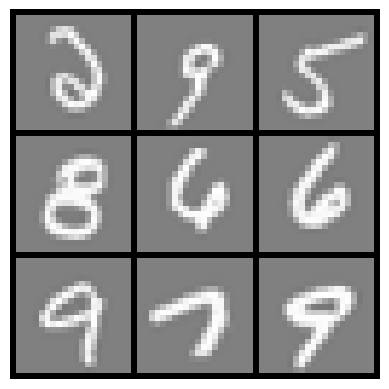

In [14]:
#绘制抽中的样本
import matplotlib.pyplot as plt
def display_data(X):
    m, n = X.shape # m是样本数，n是特征数
    example_width = int(np.round(np.sqrt(n))) # 假设每个样本是一个正方形
    example_height = n // example_width # 每个样本的高度  //（floor division)是向下取整
    display_rows = int(np.floor(np.sqrt(m))) # 显示的行数, floor是向下取整
    display_cols = int(np.ceil(m / display_rows)) # 显示的列数, ceil是向上取整
    
    pad = 1 # 每个样本之间的间隔, 1个像素, 黑框
    display_array = -np.ones((pad + display_rows * (example_height + pad), 
                              pad + display_cols * (example_width + pad)))
    
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            max_val = np.max(np.abs(X[curr_ex, :]))
            row_start = pad + j * (example_height + pad)
            col_start = pad + i * (example_width + pad)
            display_array[row_start:row_start + example_height, 
                          col_start:col_start + example_width] = \
                X[curr_ex, :].reshape(example_height, example_width).T / max_val
            curr_ex += 1
    
    plt.imshow(display_array, cmap='gray')
    plt.axis('off')
    plt.show()
display_data(X_sample)  # 显示随机选择的样本

In [15]:
Theta1.shape, Theta2.shape

((500, 401), (10, 501))

In [16]:
predictions = predict(Theta1, Theta2, X_sample)
for i in range(len(random_indices)):
    print(f"样本索引: {random_indices[i]}, 预测类别: {predictions[i]}, 真实类别: {y[random_indices[i]][0]}")

样本索引: 3711, 预测类别: 2, 真实类别: 2
样本索引: 2311, 预测类别: 9, 真实类别: 9
样本索引: 3321, 预测类别: 5, 真实类别: 5
样本索引: 3198, 预测类别: 8, 真实类别: 8
样本索引: 1080, 预测类别: 6, 真实类别: 6
样本索引: 4406, 预测类别: 6, 真实类别: 6
样本索引: 4975, 预测类别: 9, 真实类别: 9
样本索引: 1140, 预测类别: 7, 真实类别: 7
样本索引: 3186, 预测类别: 9, 真实类别: 9


In [17]:
# 计算准确率
pre = predict(Theta1, Theta2, X)
count = 0
for i in range(len(y)):
    if pre[i] == y[i]:
        count+=1
accuracy = count / len(y)
print("准确率为：", accuracy)

准确率为： 0.9712


通过调整参数（迭代次数，批次大小）可以发现批次大准确率高，批次居中速度较快,

另外NN_batch_propagation实现向量化计算，输入全批次大小速度比NN_propagation快很多

隐藏层25个神经元就可以实现就搞准确率